In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import xarray as xr
import numpy as np
import admix
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans

import dask
import dask.array as da
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json

In [2]:
SUPP_TABLE_URL = "supp_tables.xlsx"
trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name="trait-info")
trait_list = trait_info["trait"].values
dict_trait_display_name = {
    row["trait"]: row["display-name"] for _, row in trait_info.iterrows()
}
dict_trait_display_name["a1c"] = r"HbA$\mathregular{_{1c}}$"

dict_trait_category = {row.trait: row.category for _, row in trait_info.iterrows()}

In [3]:
def estimate_rg(est, est_var):
    """
    Estimate the ratio of genetic correlation.
    est: (3, ) numpy array
    est_var (3, 3) variance-covariance matrix
    """
    x, y = est[0], est[1]
    rg = y / x
    # grad = [-y / x^2, 1 / x]
    grad = np.array([-y / (x ** 2), 1 / x])

    def quad_form(x, A):
        return np.dot(np.dot(x.T, A), x)

    return rg, quad_form(grad, est_var[0:2, 0:2])

In [4]:
# df_summary = {
#     "trait": [],
#     "n_indiv": [],
#     "sigma_g": [],
#     "rho_g": [],
#     "sigma_e": [],
#     "rg": [],
# }
# df_summary = pd.DataFrame(df_summary)
# fill in for summary
#     df_summary["trait"].append(rls["trait"])
#     df_summary["n_indiv"].append(rls["n_indiv"])

#     for i, name in enumerate(["sigma_g", "rho_g", "sigma_e"]):
#         df_summary[name].append(
#             f"{rls['est'][i]:.2f} ({np.sqrt(rls['est_varcov'][i][i]):.2f})"
#         )
#     df_summary["rg"].append(f"{rls['rg']:.2f} ({np.sqrt(rls['rg_var']):.2f})")

In [9]:
df_plot

,trait,n_indiv,rg,rg_stderr,method,snpset,hermodel,pval
0,crp,8521,0.967644,0.045454,HE,hm3,gcta,2.382805e-01
1,crp,8521,0.986571,0.001105,REML,hm3,gcta,2.646429e-34
2,crp,8521,0.945947,0.060902,HE,hm3,mafukb,1.873917e-01
3,crp,8521,0.969542,0.002071,REML,hm3,mafukb,2.939416e-49
4,crp,8521,0.967240,0.043287,HE,imputed,gcta,2.245790e-01
...,...,...,...,...,...,...,...,...
187,egfrckdepi,8261,0.857871,0.019083,REML,hm3,mafukb,4.740196e-14
188,egfrckdepi,8261,0.930925,0.087016,HE,imputed,gcta,2.136506e-01
189,egfrckdepi,8261,0.924436,0.006265,REML,imputed,gcta,8.451582e-34
190,egfrckdepi,8261,0.907863,0.119323,HE,imputed,mafukb,2.200081e-01


In [11]:
df_plot = {
    "trait": [],
    "n_indiv": [],
    "rg": [],
    "rg_stderr": [],
    "method": [],
    "snpset": [],
    "hermodel": [],
}

for trait in trait_list:
    for snpset in ["hm3", "imputed"]:
        for hermodel in ["gcta", "mafukb"]:
            # HE-reg

            with open(f"out/estimate/{snpset}.{hermodel}.{trait}.json", "r") as f:
                he_rls = json.load(f)
            n_indiv = he_rls["n_indiv"]
            reml_rls = admix.tools.gcta.read_reml(
                f"out/gcta-estimate/estimate/{trait}.{snpset}.{hermodel}"
            )
            gcta_rg, gcta_rg_stderr = estimate_rg(
                reml_rls["est"]["Variance"].values, reml_rls["varcov"].values
            )
            # fill in data for plotting
            df_plot["trait"].extend([trait] * 2)
            df_plot["snpset"].extend([snpset] * 2)
            df_plot["hermodel"].extend([hermodel] * 2)
            df_plot["n_indiv"].extend([n_indiv] * 2)

            # HE-reg
            df_plot["rg"].append(he_rls["rg"])
            df_plot["rg_stderr"].append(np.sqrt(he_rls["rg_var"]))
            df_plot["method"].append("HE")

            # REML
            df_plot["rg"].append(gcta_rg)
            df_plot["rg_stderr"].append(gcta_rg_stderr)
            df_plot["method"].append("REML")

df_plot = pd.DataFrame(df_plot)
df_plot["pval"] = stats.norm.cdf((df_plot["rg"] - 1) / df_plot["rg_stderr"])
df_plot["category"] = [dict_trait_category[trait] for trait in df_plot["trait"]]
df_plot["category"] = df_plot["category"].astype("category")

In [14]:
# fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
# ax.scatter(df_plot["rg_stderr"], df_plot["gcta_rg_stderr"])
# ax.plot([0, 0.3], [0, 0.3], color="black", ls="--", alpha=0.5)

<ipython-input-33-876f1cb1a8a4>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


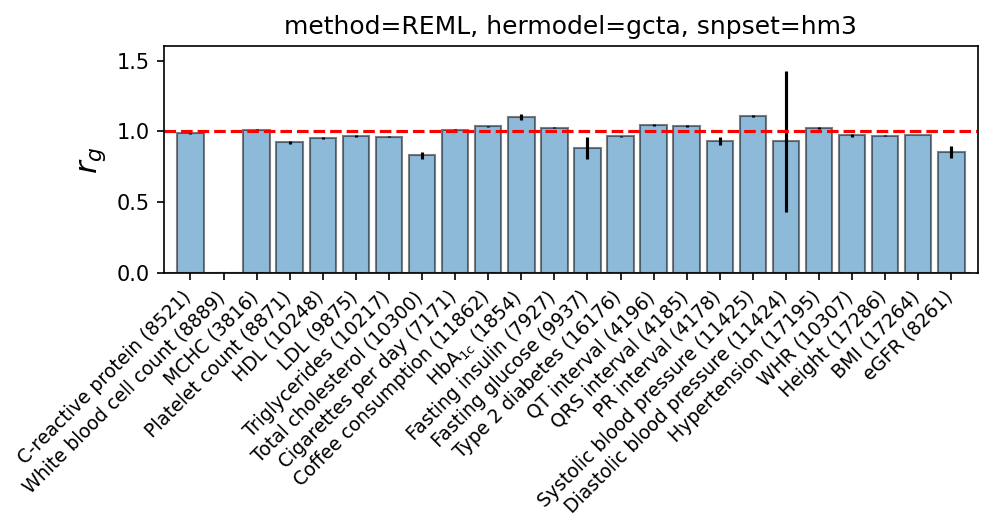

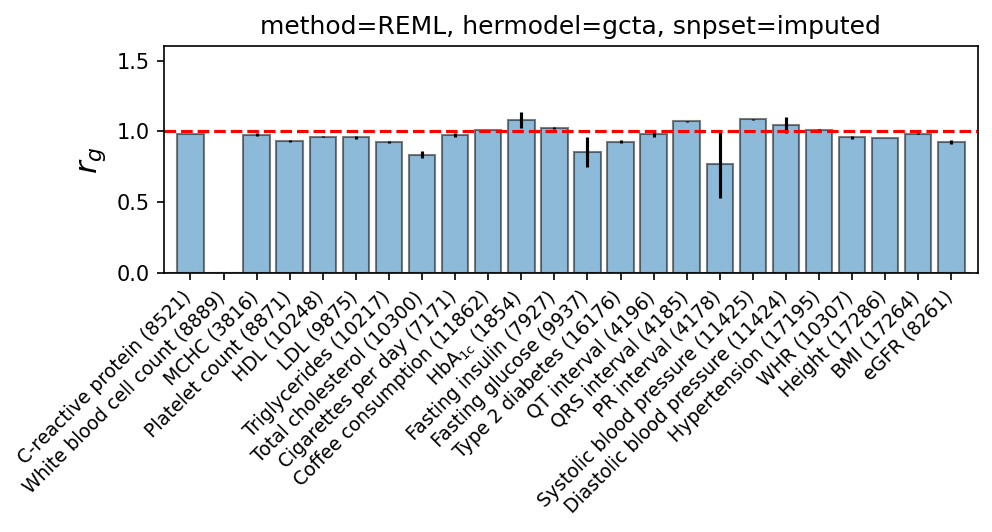

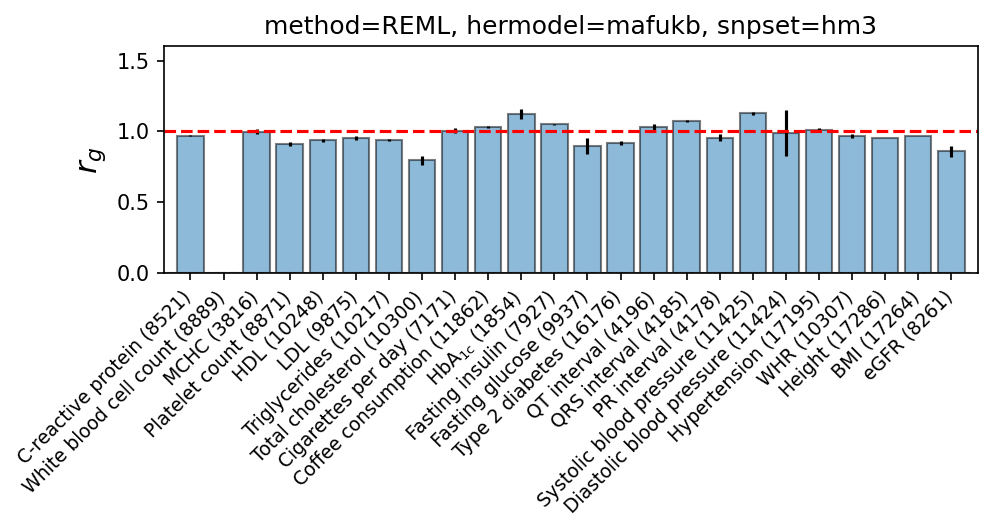

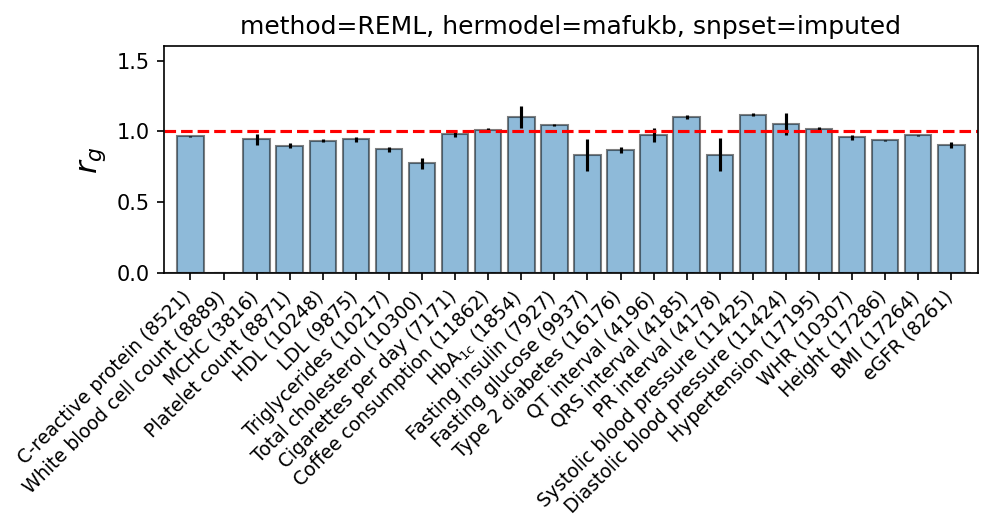

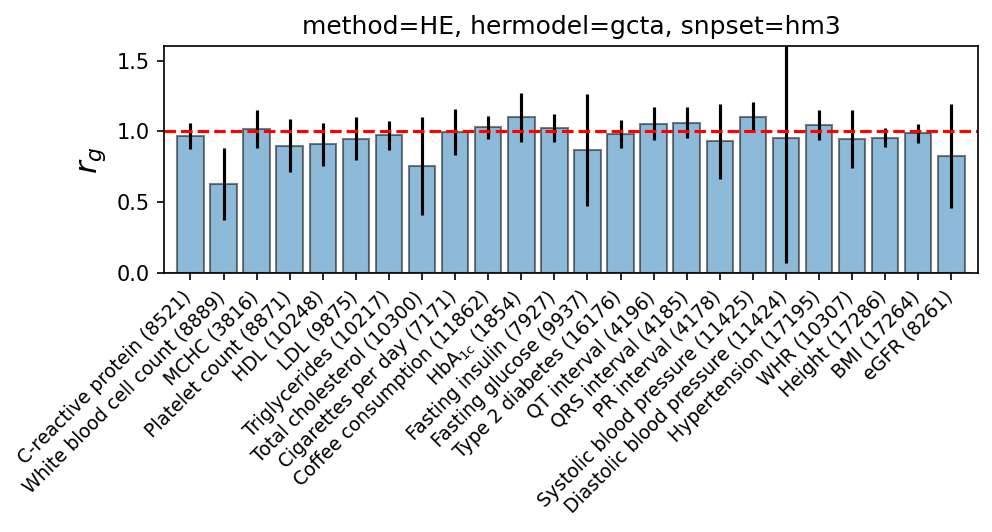

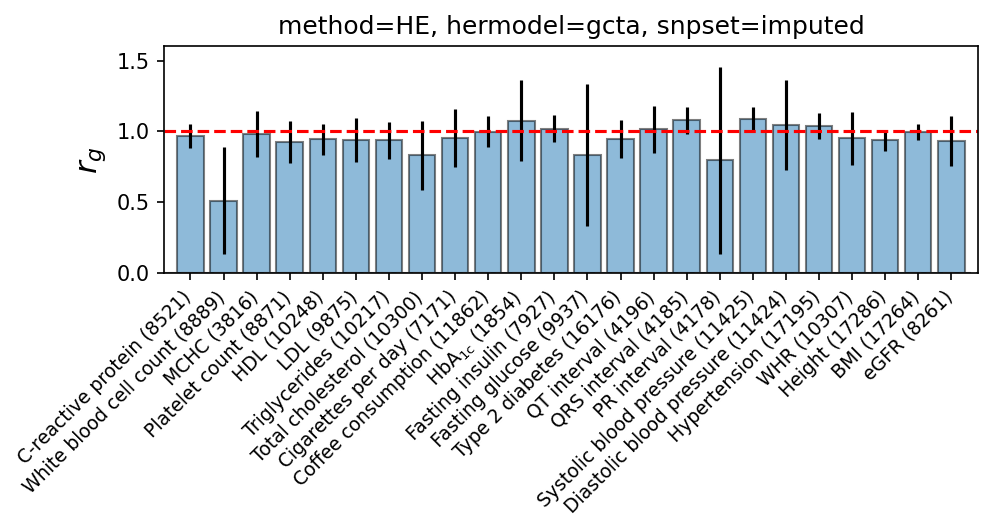

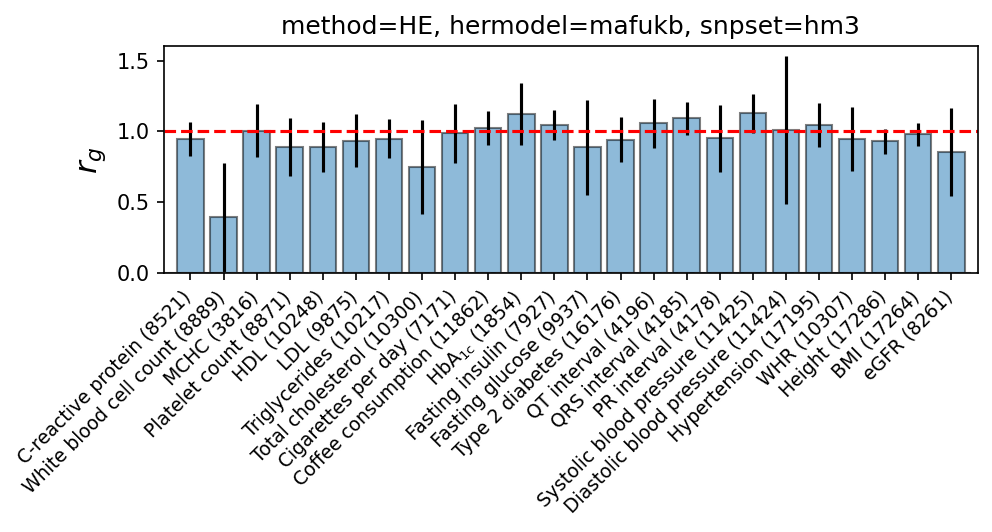

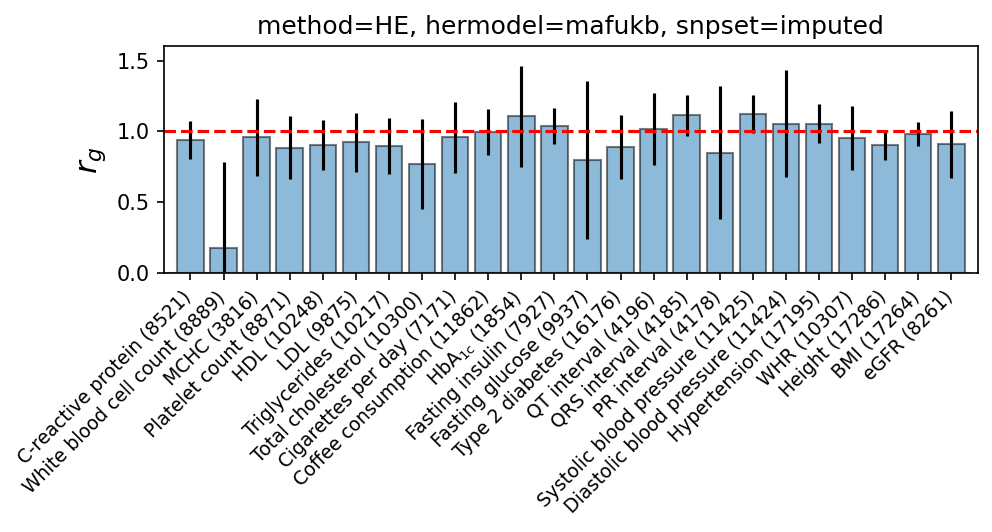

In [33]:
for method in ["REML", "HE"]:
    for hermodel in ["gcta", "mafukb"]:
        for snpset in ["hm3", "imputed"]:

            df_tmp = df_plot[
                (df_plot.method == method)
                & (df_plot.snpset == snpset)
                & (df_plot.hermodel == hermodel)
            ]
            fig, ax = plt.subplots(figsize=(7, 2), dpi=150)

            ax.bar(
                df_tmp["trait"],
                df_tmp["rg"],
                yerr=df_tmp["rg_stderr"] * 2,
                align="center",
                alpha=0.5,
                ecolor="black",
                edgecolor="black",
                capsize=0,
            )

            display_name = [
                f"{dict_trait_display_name[row.trait]} ({row.n_indiv})"
                for _, row in df_tmp.drop_duplicates(subset=["trait"]).iterrows()
            ]
            ax.set_xticklabels(
                display_name,
                rotation=45,
                va="top",
                ha="right",
                fontsize=9,
            )

            ax.axhline(y=1.0, ls="--", color="r")
            ax.axhline(y=0.0, ls="--", color="gray")
            trans = mtrans.Affine2D().translate(5, 0)
            for t in ax.get_xticklabels():
                t.set_transform(t.get_transform() + trans)

            ax.set_ylabel("$r_g$", fontsize=15)
            ax.set_title(f"method={method}, hermodel={hermodel}, snpset={snpset}")
            fig.show()

            ax.set_ylim(0, 1.6)
            ax.set_xlim(-0.8, 23.8)

<ipython-input-16-e34c5ba4ecd1>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


(-0.8, 23.8)

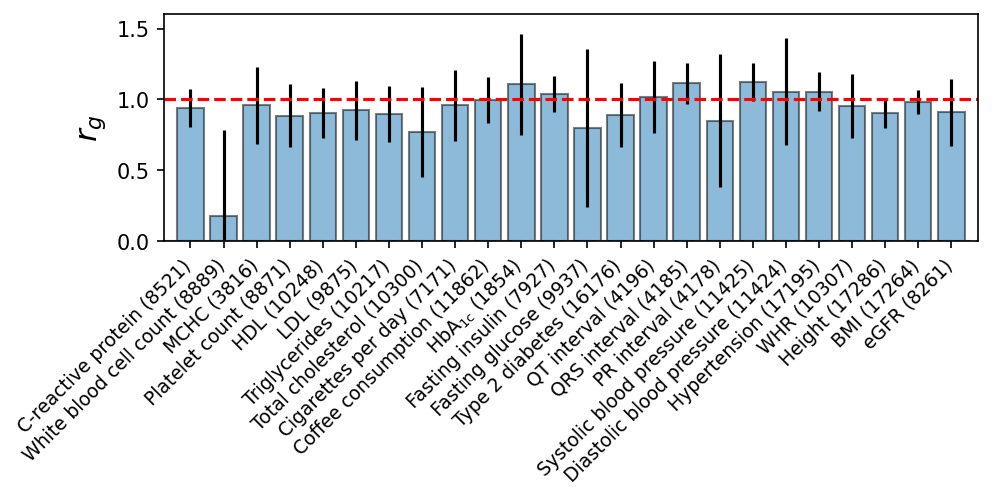

In [16]:
fig, ax = plt.subplots(figsize=(7, 2), dpi=150)

ax.bar(
    df_plot["trait"],
    df_plot["rg"],
    yerr=df_plot["rg_stderr"] * 2,
    align="center",
    alpha=0.5,
    ecolor="black",
    edgecolor="black",
    capsize=0,
)

display_name = [
    f"{dict_trait_display_name[row.trait]} ({row.n_indiv})"
    for _, row in df_plot.iterrows()
]
ax.set_xticklabels(
    display_name,
    rotation=45,
    va="top",
    ha="right",
    fontsize=9,
)

ax.axhline(y=1.0, ls="--", color="r")
ax.axhline(y=0.0, ls="--", color="gray")
trans = mtrans.Affine2D().translate(5, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform() + trans)

ax.set_ylabel("$r_g$", fontsize=15)
fig.show()

ax.set_ylim(0, 1.6)
ax.set_xlim(-0.8, 23.8)

<ipython-input-17-b2452344194e>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


(0.0, 2.0)

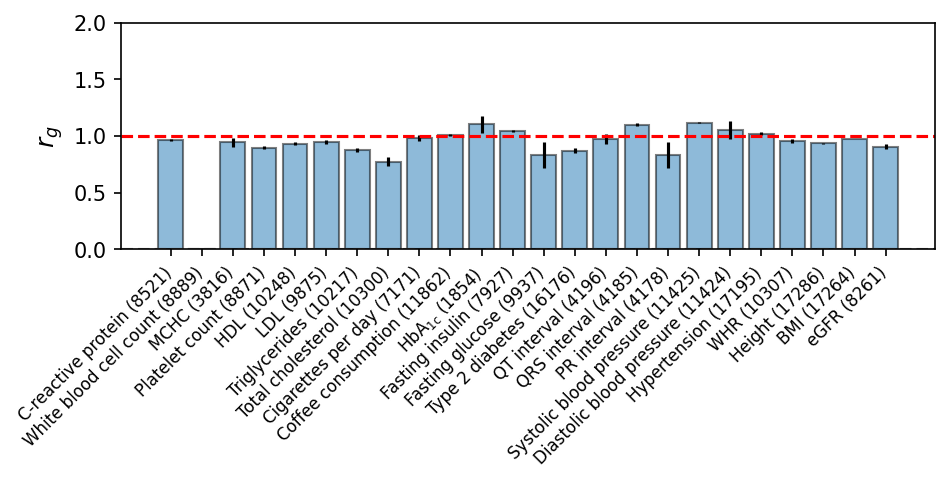

In [17]:
fig, ax = plt.subplots(figsize=(7, 2), dpi=150)

ax.bar(
    df_plot["trait"],
    df_plot["gcta_rg"],
    yerr=df_plot["gcta_rg_stderr"] * 2,
    align="center",
    alpha=0.5,
    ecolor="black",
    edgecolor="black",
    capsize=0,
)

display_name = [
    f"{dict_trait_display_name[row.trait]} ({row.n_indiv})"
    for _, row in df_plot.iterrows()
]
ax.set_xticklabels(
    display_name,
    rotation=45,
    va="top",
    ha="right",
    fontsize=8,
)

ax.axhline(y=1.0, ls="--", color="r")
ax.axhline(y=0.0, ls="--", color="gray")
trans = mtrans.Affine2D().translate(5, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform() + trans)

ax.set_ylabel("$r_g$", fontsize=12)
fig.show()

ax.set_ylim(0, 2)